In [33]:
import mlrun
print(mlrun.__version__)

1.6.1


In [40]:
project_name = 'github-example'
project = mlrun.get_or_create_project(project_name, context="./")
project.set_source(source="git://github.com/xsqian/mlrun-github-example.git#main", pull_at_runtime=True)

> 2024-04-30 22:16:40,163 [info] Project loaded successfully: {'project_name': 'github-example'}


In [41]:
# project.set_secrets(secrets={"GIT_TOKEN" : ""}, provider="kubernetes")

In [60]:
%%writefile coffeerating-data-generator.py
import pandas as pd
from sklearn import model_selection
from sklearn.linear_model import LinearRegression

def coffeerating_data_generator(context):
    raw = pd.read_csv("https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-07-07/coffee_ratings.csv")
    df = pd.DataFrame(raw)
    coffee = pd.DataFrame(df[
        [
            "total_cup_points",
            "aroma",
            "flavor",
            "sweetness",
            "acidity",
            "body",
            "uniformity",
            "balance",
        ]
    ])
    print("******************** running with main branch git://github.com/xsqian/mlrun-github-example.git#main ********************")
    # mlrun expr 
    context.log_dataset("coffee_dataset", df=coffee, format='parquet', index=False, artifact_path=context.artifact_subpath('coffee-dataset'))
    # context.log_artifact('coffee_dataset', body=raw, format='csv')
    return coffee, 'outcome'

Overwriting coffeerating-data-generator.py


In [63]:
coffee_data_gen_fn = project.set_function(name='coffeerating-data-function', 
                                          kind="job", 
                                          image="mlrun/mlrun:1.6.1", 
                                          func='coffeerating-data-generator.py', 
                                          handler='coffeerating_data_generator', with_repo=True)

In [64]:
coffee_data_run = project.run_function(coffee_data_gen_fn,local=False)

> 2024-04-30 22:26:30,975 [info] Storing function: {'name': 'coffeerating-data-function-coffeerating-data-generator', 'uid': '5b52180705eb4676900663a4be24deb8', 'db': 'http://mlrun-api:8080'}
> 2024-04-30 22:26:31,281 [info] Job is running in the background, pod: coffeerating-data-function-coffeerating-data-generator-vw7kc
> 2024-04-30 22:26:34,394 [info] extracting source from git://github.com/xsqian/mlrun-github-example.git#main to /mlrun/code
> 2024-04-30 22:26:35,403 [info] To track results use the CLI: {'info_cmd': 'mlrun get run 5b52180705eb4676900663a4be24deb8 -p github-example', 'logs_cmd': 'mlrun logs 5b52180705eb4676900663a4be24deb8 -p github-example'}
> 2024-04-30 22:26:35,403 [info] Or click for UI: {'ui_url': 'https://dashboard.default-tenant.app.cst-354.iguazio-cd2.com/mlprojects/github-example/jobs/monitor/5b52180705eb4676900663a4be24deb8/overview'}
> 2024-04-30 22:26:35,403 [info] Run execution finished: {'status': 'completed', 'name': 'coffeerating-data-function-coffee

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
github-example,...be24deb8,0,Apr 30 22:26:34,completed,coffeerating-data-function-coffeerating-data-generator,v3io_user=xingshengkind=jobowner=xingshengmlrun/client_version=1.6.1mlrun/client_python_version=3.9.16host=coffeerating-data-function-coffeerating-data-generator-vw7kc,,,"return=( total_cup_points aroma flavor ... body uniformity balance\n0 90.58 8.67 8.83 ... 8.50 10.00 8.42\n1 89.92 8.75 8.67 ... 8.42 10.00 8.42\n2 89.75 8.42 8.50 ... 8.33 10.00 8.42\n3 89.00 8.17 8.58 ... 8.50 10.00 8.25\n4 88.83 8.25 8.50 ... 8.42 10.00 8.33\n... ... ... ... ... ... ... ...\n1334 78.75 7.75 7.58 ... 5.08 10.00 7.83\n1335 78.08 7.50 7.67 ... 5.17 10.00 5.25\n1336 77.17 7.33 7.33 ... 7.50 9.33 7.17\n1337 75.08 7.42 6.83 ... 7.25 9.33 7.00\n1338 73.75 6.75 6.67 ... 6.92 9.33 6.83\n\n[1339 rows x 8 columns], 'outcome')",coffee_dataset


> 2024-04-30 22:26:42,428 [info] Run execution finished: {'status': 'completed', 'name': 'coffeerating-data-function-coffeerating-data-generator'}


In [65]:
%%writefile trainer.py

import pandas as pd
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
import mlrun
from mlrun.frameworks.sklearn import apply_mlrun

@mlrun.handler()
def train(context,
    dataset: pd.DataFrame,
    model_name: str = "lr_fit"
    ):
    
    x = dataset.drop('total_cup_points', axis=1)
    y = dataset['total_cup_points']
    X_train, X_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.2)

    model = LinearRegression()

    apply_mlrun(model=model, model_name=model_name, x_test=X_test, y_test=y_test)

    model.fit(X_train, y_train)
    print("******************** running with main branch git://github.com/xsqian/mlrun-github-example.git#main ********************")


Overwriting trainer.py


In [68]:
trainer = project.set_function("trainer.py", name="coffeerating-trainer", kind="job", image="mlrun/mlrun:1.6.1", handler="train", with_repo=True)

In [69]:
trainer_run = project.run_function("coffeerating-trainer", inputs={"dataset": coffee_data_run.outputs['coffee_dataset']}, local=False)
trainer_run.outputs

> 2024-04-30 22:28:02,916 [info] Storing function: {'name': 'coffeerating-trainer-train', 'uid': '638f99a36d0d4d56b09f4fb5efef21e2', 'db': 'http://mlrun-api:8080'}
> 2024-04-30 22:28:03,195 [info] Job is running in the background, pod: coffeerating-trainer-train-dmks4
> 2024-04-30 22:28:06,310 [info] extracting source from git://github.com/xsqian/mlrun-github-example.git#main to /mlrun/code
> 2024-04-30 22:28:07,271 [info] downloading v3io:///projects/github-example/artifacts/coffee-dataset/coffeerating-data-function-coffeerating-data-generator/0/coffee_dataset.parquet to local temp file
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

> 2024-04-30 22:28:07,980 [info] To track results use the CLI: {'info_cmd': 'mlrun get run 638f99a36d0d4d56b09f4fb5efef21e2 -p github-example', 'logs_cmd': 'mlru

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
github-example,...efef21e2,0,Apr 30 22:28:06,completed,coffeerating-trainer-train,v3io_user=xingshengkind=jobowner=xingshengmlrun/client_version=1.6.1mlrun/client_python_version=3.9.16host=coffeerating-trainer-train-dmks4,dataset,,mean_absolute_error=0.3576666708615268r2_score=0.9294044319684496root_mean_squared_error=0.6662978967481452mean_squared_error=0.44395288721100196,feature-importancetest_setmodel


> 2024-04-30 22:28:14,327 [info] Run execution finished: {'status': 'completed', 'name': 'coffeerating-trainer-train'}


{'mean_absolute_error': 0.3576666708615268,
 'r2_score': 0.9294044319684496,
 'root_mean_squared_error': 0.6662978967481452,
 'mean_squared_error': 0.44395288721100196,
 'feature-importance': 'v3io:///projects/github-example/artifacts/coffeerating-trainer-train/0/feature-importance.html',
 'test_set': 'store://artifacts/github-example/coffeerating-trainer-train_test_set@638f99a36d0d4d56b09f4fb5efef21e2',
 'model': 'store://artifacts/github-example/lr_fit@638f99a36d0d4d56b09f4fb5efef21e2'}

In [70]:
%%writefile './workflow.py'

from kfp import dsl
import mlrun

# Create a Kubeflow Pipelines pipeline
@dsl.pipeline(
    name="Coffee Rating Pipeline"
)
def pipeline():
    
    # Run the data creationg function
    ingest = mlrun.run_function(
        "coffeerating_data_function",
        name="coffee-data-generation-step",
        outputs=['coffee_dataset'],
        local=False,
    )

    # Train a model using the trainer function
    train = mlrun.run_function(
        "coffeerating-trainer",
        inputs={"dataset": ingest.outputs['coffee_dataset']},
        outputs=["model"],
        local=False
    )

Overwriting ./workflow.py


In [71]:
project.set_workflow('main', 'workflow.py')

In [72]:
print(project.to_yaml())

kind: project
metadata:
  name: github-example
  created: '2024-04-30T22:01:03.539000'
spec:
  functions:
  - url: my_job_code.py
    name: greetings
    kind: job
    image: mlrun/mlrun:1.4.1
    handler: handler
    with_repo: true
  - url: coffeerating-data-generator.py
    name: coffeerating-data-function
    kind: job
    image: mlrun/mlrun:1.6.1
    handler: coffeerating_data_generator
    with_repo: true
  - url: trainer.py
    name: coffeerating-trainer
    kind: job
    image: mlrun/mlrun:1.6.1
    handler: train
    with_repo: true
  - url: src/func1.py
    name: function1
    kind: job
    image: mlrun/mlrun:1.4.1
    handler: handler
    with_repo: true
  workflows:
  - path: workflow.py
    name: main
  - path: ./schedule-workflow.py
    name: testing
    schedule: '*/10 * * * *'
  - path: ./schedule-workflow.py
    name: testing-scheduled-workflow
    schedule: '*/10 * * * *'
  - path: src/schedule-workflow.py
    name: testing-schedule
    schedule: '*/10 * * * *'
  arti

In [73]:
project.save()

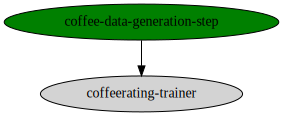

In [ ]:
run_id = project.run('main', watch=True, dirty=True)

In [13]:
run_id = project.run('main', dirty=True, schedule='*/10 * * * *')

> 2023-08-30 04:26:48,081 [warning] WARNING!, you seem to have uncommitted git changes, use .push()
> 2023-08-30 04:26:48,086 [info] executing workflow scheduling 'workflow-runner-main' remotely with kfp engine
> 2023-08-30 04:26:48,089 [info] Storing function: {'name': 'main', 'uid': '5f0d6f7b583349e2ad98349cb4f13381', 'db': None}
> 2023-08-30 04:26:48,698 [info] task schedule modified: {'schedule': '*/10 * * * *', 'project': 'gitlab-example', 'name': 'main'}
